In [1]:
import pickle
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile
import yaml

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [6]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/submission_v1'

In [8]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

## define inputs

In [9]:
dirs = [os.path.join(run_dir, root)
        for root in os.listdir(run_dir)
        if root not in ['lightsheet', 'kidney']]
dirs = sorted(dirs)
[x.split('/')[-1] for x in dirs]


['C3L-00970',
 'C3L-00982',
 'C3L-01287',
 'C3L-02551',
 'HT206B1',
 'HT225C1',
 'HT268B1',
 'HT339B2-H1',
 'HT397B1',
 'HT413C1-K2',
 'HT413C1-Th1k4A1',
 'HT448C1-Th1K1Fp1',
 'HT553P1-H2',
 'HT565B1-H2',
 'S18-25943-A7',
 'S18-5591-C8',
 'S18-9906',
 'WD-76845',
 'analysis']

In [10]:
z_scaler = .2
cluster_resolutions = [1., 1.5, 2.]
# nbhd_resolutions = [25, 50, 100, 150, 200]
nbhd_resolutions = [50]
nbhd_resolution_visium = 100

In [11]:
# fix issues where antibody names aren't consistent accross some images
channel_to_idents = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'PanCK', 'PanCytokeratin'],
    'E-cadherin': ['E-cadherin', 'E-Cadherin'],
    'CD45': ['CD45'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin', 'Vim', 'VIM'],
    'SMA': ['SMA', 'a-SMA'],
    'CD31': ['CD31'],
    'CD20': ['CD20', 'CD20-Akoya'],
    'CD68': ['CD68'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKit', 'cKIT', 'ckit-(D)', 'ckit'],
    'MGP': ['MGP'],
    'CD36': ['CD36'],
    'PR': ['PR'],
    'ER': ['ER'],
    'P21': ['P21'],
    'P16': ['P16'],
    'CK5': ['Keratin 5', 'KRT5', 'CK5'],
    'CK7': ['CK7'],
    'CK8/18': ['CK8/18'],
    'TFF1': ['TFF1'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'KRT14'],
    'CK17': ['CK17', 'Keratin 17', 'CK17'],
    'CK19': ['CK19', 'Keratin 19', 'KRT19'],
    'CD11b': ['CD11b', 'CD11B', 'cd11b'],
    'GATA3': ['GATA3'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT'],
    'COX6c': ['COX6c', 'COX6C (D)', 'COX6C'],
    'Her2': ['Her2', 'HER2'],
    'Bap1': ['Bap1', 'BAP1'],
    'GLUT1': ['Glut1', 'GLUT1'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR', 'HLADR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN'],
    'CTLA4': ['CTLA4'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3'],
    'PTPRZ1': ['PTPRZ1'],
    'HIF1A': ['HIF1a', 'HIF1A'],
    'PAI1': ['PAI1'],
    'GFAP': ['GFAP'],
    'VEGFA': ['VEGFA'],
    'IBA1': ['IBA1'],
    'OLIG2': ['OLIG2'],
    'FN1': ['FN1'],
    'a-Amylase': ['a-Amylase', 'Amylase (D', 'Amylase'],
    'Hep-Par-1': ['Hep-Par-1', 'HepPar1-(D)', 'HepPar1'],
    'Granzyme-B': ['Granzyme B', 'GZMB'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1', 'PD1'],
    'PDL1': ['PD-L1', 'PDL1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63', 'p63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1', 'LYVE1'],
    'CCL2': ['CCL2'],
    'MUC2': ['MUC2'],
    'SOX9': ['SOX9'],
    'STEAP4': ['STEAP4'],
    'AR': ['AR'],
    'AMACR': ['AMACR'],
    'PGC': ['PGC', 'PGC (D)'],
    'CFTR': ['CFTR (D)', 'CFTR'],
    'REG3A': ['REG3A (D)', 'REG3A'],
    'LAMC2': ['LAMC2 (D)', 'LAMC2'],
    'INS': ['INS (D)', 'INS'],
    'CRP': ['CRP (D)', 'CRP'],
    'CD74': ['CD74 (D)', 'CD74'],
    'MUC5AC': ['MUC5AC (D)', 'MUC5AC'],
    'AQP1': ['AQP1'],
    'AQP2': ['Aqp2', 'AQP2'], 
    'LRP2': ['LRP2'],
    'UMOD': ['UMOD'],
    'CALB1': ['CALB1'],
    'CP': ['CP'],
    'CA9': ['CA9'],
    'UCHL1': ['UCHL1'],
}
channel_mapping = {v:k for k, vs in channel_to_idents.items() for v in vs}

# add in (D) variants
variants = ['(D)', ' (D)', '(d)', ' (d)', '-(D)', '-(d)', ' (Dnew)', '(Dnew)', '-(Dnew)']
channel_mapping.update({k + variant:v
                      for k, v in channel_mapping.items()
                      for variant in variants})

In [12]:
dtype_to_weight_mapping = {
    'HT413C1-Th1k4A1': {
        'he': 1.,
        'multiplex': 1.,
        'xenium': 1.,
        'cosmx': 0. # cosmx just kinda sucks
    },
    'HT397B1': {
        'he': 0., # ignoring visium H&E
        'visium': 1.,
        'multiplex': 1.,
        'batch2_he': 1.
    },
    'S18-9906': {
        'he': 0., # ignoring visium H&E
        'visium': 1.,
        'multiplex': 1.,
        'batch2_he': 1.,
        'xenium': 1.
    },
}

exclusion_mapping = {
    'HT413C1-Th1k4A1': ['HT413C1-Th1k4A1-U31'], # one of the xenium slides has detachment issues
}

In [13]:
def get_n_steps(n_sections):
    if n_sections < 10:
        return 1000
    elif n_sections < 20:
        return 2000
    else:
        return 4000
    

In [14]:
cases = [
#     'C3L-00970',
#     'C3L-00982',
#     'C3L-01287',
#     'C3L-02551',
#     'HT206B1',
#     'HT225C1',
#     'HT268B1',
#     'HT339B2-H1',
#     'HT397B1',
#     'HT413C1-K2',
    'HT413C1-Th1k4A1',
#     'HT448C1-Th1K1Fp1',
#     'HT553P1-H2',
#     'HT565B1-H2',
#     'S18-25943-A7',
#     'S18-5591-C8',
#     'S18-9906',
#     'WD-76845',
]

In [16]:
case_to_config = {}
for case in cases:
    for target_res in nbhd_resolutions:
        metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))
        
        if case in exclusion_mapping:
            metadata['sections'] = [x for x in metadata['sections'] if x['sid'] not in exclusion_mapping[case]]

        config = deepcopy(DEFAULT_CONFIG)

#         mask_fp = os.path.join(run_dir, case, 'masks', 'tissue_mask.tif')
#         if not os.path.exists(mask_fp):
#             mask_fp = None
        mask_fp = None # running without masks

        config = utils.recursive_update(config, {
            'sections': metadata['sections'],
            'trainer_kwargs': {
                'input_resolution': metadata['resolution'],
                'target_resolution': target_res,
                'out_dir': os.path.join(run_dir, case, f'mushroom_{target_res}res'),
                'accelerator': 'gpu',
#                 'steps_per_epoch': n_steps, setting later for each dtype
                'data_mask': mask_fp,
            }
        })

        config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
            'visium': {
                'trainer_kwargs': {
                    'target_resolution': max(nbhd_resolution_visium, target_res)  # lower resolution for visium
                }
            },
            'multiplex': {
                'trainer_kwargs': {
                    'channel_mapping': channel_mapping
                }
            }
        })
        
        dtypes = set([mapping['dtype'] for entry in metadata['sections'] for mapping in entry['data']])
        for dtype in dtypes:
            n_sections = len([mapping
                              for entry in metadata['sections']
                              for mapping in entry['data']
                              if mapping['dtype'] == dtype])
            
            config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
                dtype: {
                    'trainer_kwargs': {
                        'steps_per_epoch': get_n_steps(n_sections)
                    }
                }
            })

        config = alter_filesystem(config, source_root, target_root)
        
        case_to_config[(case, target_res)] = config

In [17]:
case_to_config.keys()

dict_keys([('HT413C1-Th1k4A1', 50)])

In [18]:
# case_to_config[('WD-76845', 0.01)]

In [19]:
# mushroom = Mushroom.from_config(case_to_config[('HT225C1', 100.)])
# mushroom

In [20]:
# for dt in mushroom.dtypes:
#     x = next(iter(mushroom.dtype_to_spore[dt].train_dl.dataset.section_to_img.values()))
#     print(dt, x.shape)
#     print(mushroom.input_ppm, mushroom.target_ppm)

In [21]:
# ppm = .3
# target_ppm = 100.
# int(ppm / target_ppm)
# int(ppm / (1 / target_ppm))

In [22]:
config

{'sections': [{'data': [{'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s0_HT413C1-Th1k4A1-U14_he.tif'}],
   'position': 0,
   'sid': 'HT413C1-Th1k4A1-U14'},
  {'data': [{'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s1_HT413C1-Th1k4A1-U18_he.tif'}],
   'position': 20,
   'sid': 'HT413C1-Th1k4A1-U18'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s2_HT413C1-Th1k4A1-U19_xenium.h5ad'}],
   'position': 25,
   'sid': 'HT413C1-Th1k4A1-U19'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s3_HT413C1-Th1k4A1-U20_multiplex.ome.tiff'}],
   'position': 30,
   'sid': 'HT413C1-Th1k4A1-U20'},
  {'data': [{'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/regi

## train mushroom

INFO:root:loading spore for cosmx
INFO:root:data mask detected
INFO:root:starting cosmx processing


HT413C1-Th1k4A1 50


INFO:root:using 1000 channels
INFO:root:2 sections detected: ['HT413C1-Th1k4A1-U7', 'HT413C1-Th1k4A1-U34']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U7
INFO:root:generating image data for section HT413C1-Th1k4A1-U34
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT413C1-Th1k4A1-U7', 'cosmx'), ('HT413C1-Th1k4A1-U34', 'cosmx')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpcqotz9k9
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpcqotz9k9/_remote_module_non_scriptable.py
INFO:root:creating ViT


cosmx torch.Size([1000, 102, 73])


INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:14 sections detected: ['HT413C1-Th1k4A1-U14', 'HT413C1-Th1k4A1-U18', 'HT413C1-Th1k4A1-U1', 'HT413C1-Th1k4A1-U4', 'HT413C1-Th1k4A1-U8', 'HT413C1-Th1k4A1-U11', 'HT413C1-Th1k4A1-U21', 'HT413C1-Th1k4A1-U24', 'HT413C1-Th1k4A1-U27', 'HT413C1-Th1k4A1-U29', 'HT413C1-Th1k4A1-U30', 'HT413C1-Th1k4A1-U35', 'HT413C1-Th1k4A1-U38', 'HT413C1-Th1k4A1-U40']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U14
INFO:root:generating image data for section HT413C1-Th1k4A1-U18


0.02


INFO:root:generating image data for section HT413C1-Th1k4A1-U1
INFO:root:generating image data for section HT413C1-Th1k4A1-U4
INFO:root:generating image data for section HT413C1-Th1k4A1-U8
INFO:root:generating image data for section HT413C1-Th1k4A1-U11
INFO:root:generating image data for section HT413C1-Th1k4A1-U21
INFO:root:generating image data for section HT413C1-Th1k4A1-U24
INFO:root:generating image data for section HT413C1-Th1k4A1-U27
INFO:root:generating image data for section HT413C1-Th1k4A1-U29
INFO:root:generating image data for section HT413C1-Th1k4A1-U30
INFO:root:generating image data for section HT413C1-Th1k4A1-U35
INFO:root:generating image data for section HT413C1-Th1k4A1-U38
INFO:root:generating image data for section HT413C1-Th1k4A1-U40
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 14 sections detected: [('HT413C1-Th1k4A1-U14', 'he'), ('HT413C1-Th1k4A1-U18', 'he'), ('HT413C1-Th1k4A1-U1', 'he'), ('HT413C1-Th1k4A1-U4', '

he torch.Size([3, 101, 72])


INFO:root:using 27 channels
INFO:root:7 sections detected: ['HT413C1-Th1k4A1-U20', 'HT413C1-Th1k4A1-U3', 'HT413C1-Th1k4A1-U26', 'HT413C1-Th1k4A1-U32', 'HT413C1-Th1k4A1-U37', 'HT413C1-Th1k4A1-U41', 'HT413C1-Th1k4A1-U42']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U20


0.02


INFO:root:generating image data for section HT413C1-Th1k4A1-U3
INFO:root:generating image data for section HT413C1-Th1k4A1-U26
INFO:root:generating image data for section HT413C1-Th1k4A1-U32
INFO:root:generating image data for section HT413C1-Th1k4A1-U37
INFO:root:generating image data for section HT413C1-Th1k4A1-U41
INFO:root:generating image data for section HT413C1-Th1k4A1-U42
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 7 sections detected: [('HT413C1-Th1k4A1-U20', 'multiplex'), ('HT413C1-Th1k4A1-U3', 'multiplex'), ('HT413C1-Th1k4A1-U26', 'multiplex'), ('HT413C1-Th1k4A1-U32', 'multiplex'), ('HT413C1-Th1k4A1-U37', 'multiplex'), ('HT413C1-Th1k4A1-U41', 'multiplex'), ('HT413C1-Th1k4A1-U42', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

multiplex torch.Size([27, 101, 72])


INFO:root:using 477 channels
INFO:root:5 sections detected: ['HT413C1-Th1k4A1-U19', 'HT413C1-Th1k4A1-U2', 'HT413C1-Th1k4A1-U9', 'HT413C1-Th1k4A1-U25', 'HT413C1-Th1k4A1-U36']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U19
INFO:root:generating image data for section HT413C1-Th1k4A1-U2
INFO:root:generating image data for section HT413C1-Th1k4A1-U9
INFO:root:generating image data for section HT413C1-Th1k4A1-U25
INFO:root:generating image data for section HT413C1-Th1k4A1-U36
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 5 sections detected: [('HT413C1-Th1k4A1-U19', 'xenium'), ('HT413C1-Th1k4A1-U2', 'xenium'), ('HT413C1-Th1k4A1-U9', 'xenium'), ('HT413C1-Th1k4A1-U25', 'xenium'), ('HT413C1-Th1k4A1-U36', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, us

xenium torch.Size([477, 102, 73])
[('HT413C1-Th1k4A1-U14', 'he'), ('HT413C1-Th1k4A1-U18', 'he'), ('HT413C1-Th1k4A1-U19', 'xenium'), ('HT413C1-Th1k4A1-U20', 'multiplex'), ('HT413C1-Th1k4A1-U1', 'he'), ('HT413C1-Th1k4A1-U2', 'xenium'), ('HT413C1-Th1k4A1-U3', 'multiplex'), ('HT413C1-Th1k4A1-U4', 'he'), ('HT413C1-Th1k4A1-U7', 'cosmx'), ('HT413C1-Th1k4A1-U8', 'he'), ('HT413C1-Th1k4A1-U9', 'xenium'), ('HT413C1-Th1k4A1-U11', 'he'), ('HT413C1-Th1k4A1-U21', 'he'), ('HT413C1-Th1k4A1-U24', 'he'), ('HT413C1-Th1k4A1-U25', 'xenium'), ('HT413C1-Th1k4A1-U26', 'multiplex'), ('HT413C1-Th1k4A1-U27', 'he'), ('HT413C1-Th1k4A1-U29', 'he'), ('HT413C1-Th1k4A1-U30', 'he'), ('HT413C1-Th1k4A1-U32', 'multiplex'), ('HT413C1-Th1k4A1-U34', 'cosmx'), ('HT413C1-Th1k4A1-U35', 'he'), ('HT413C1-Th1k4A1-U36', 'xenium'), ('HT413C1-Th1k4A1-U37', 'multiplex'), ('HT413C1-Th1k4A1-U38', 'he'), ('HT413C1-Th1k4A1-U40', 'he'), ('HT413C1-Th1k4A1-U41', 'multiplex'), ('HT413C1-Th1k4A1-U42', 'multiplex')]
cosmx torch.Size([1000, 102, 

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/cosmx_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 6.7 M 
------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.969    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training cosmx, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/cosmx_chkpts/last-v1.ckpt
INFO:root:starting training for he
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/he_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.874    Total estimated model params size (MB)


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/he_chkpts/last-v1.ckpt
INFO:root:starting training for multiplex
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/multiplex_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.918    Total estimated model params size (MB)


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/multiplex_chkpts/last-v1.ckpt
INFO:root:starting training for xenium
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/xenium_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.992    Total estimated model params size (MB)


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/xenium_chkpts/last-v1.ckpt
INFO:root:embedding cosmx spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                       | 0/? [00:…

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

INFO:fontTools.subset:maxp pruned


cosmx 0


INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 10 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 10 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24]
INFO:fontTools.subset:Closing glyph list over 'MATH': 10 glyphs before
INFO:fontTools.subset:Glyph names: ['.notd

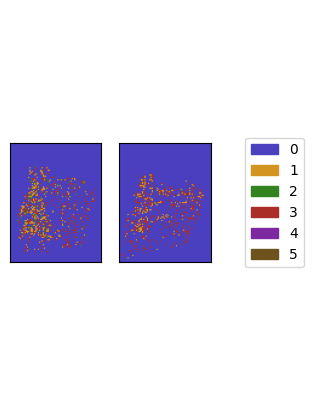

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

cosmx 1


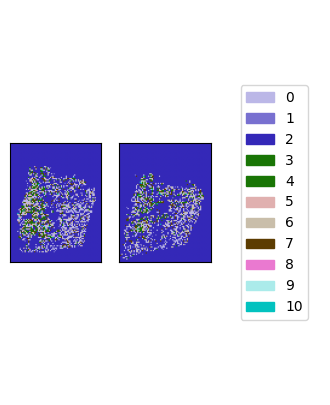

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

cosmx 2


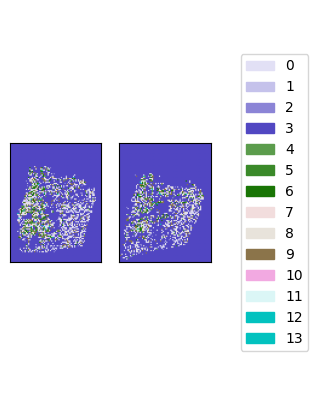

he 0


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 12 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 12 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closing g

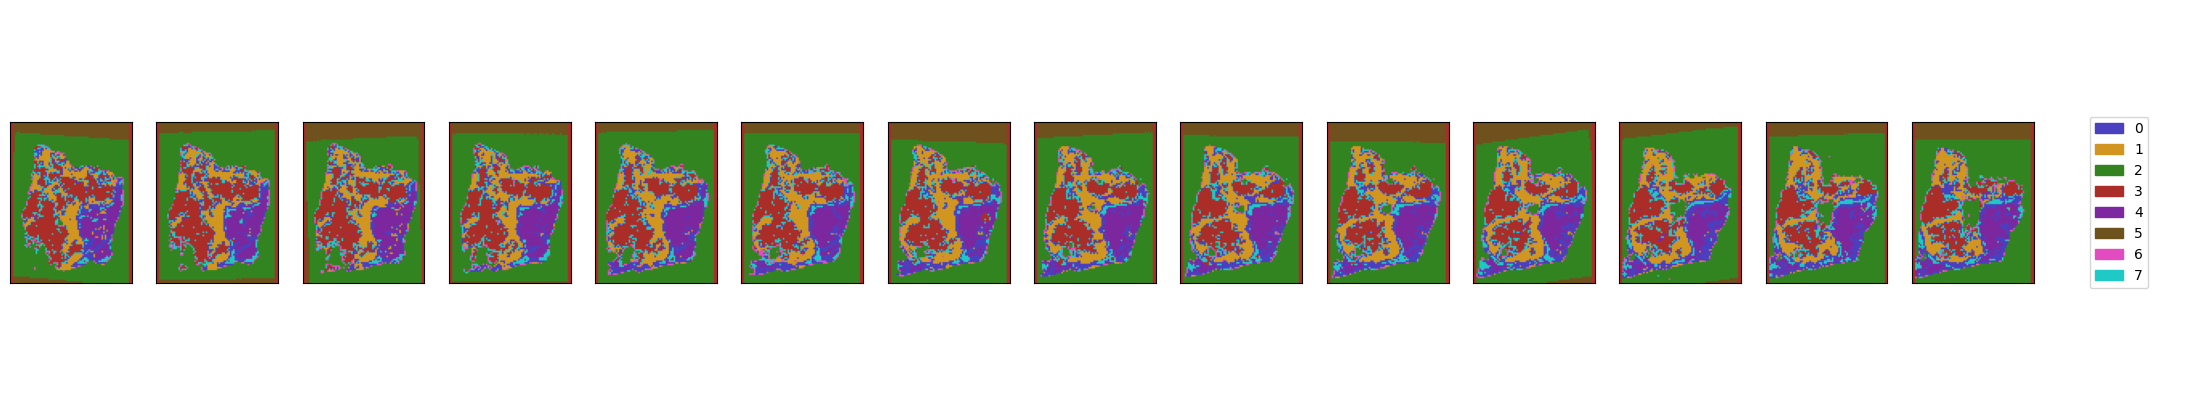

he 1


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

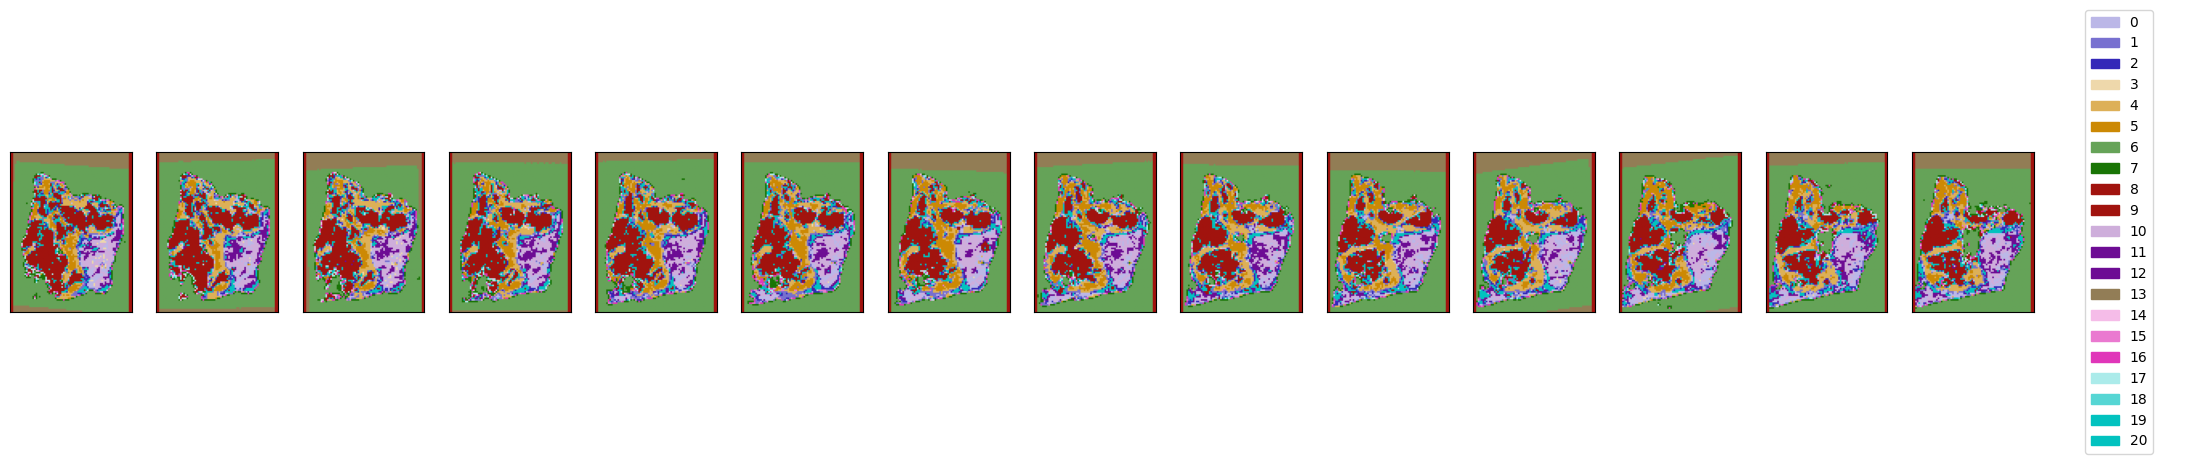

he 2


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

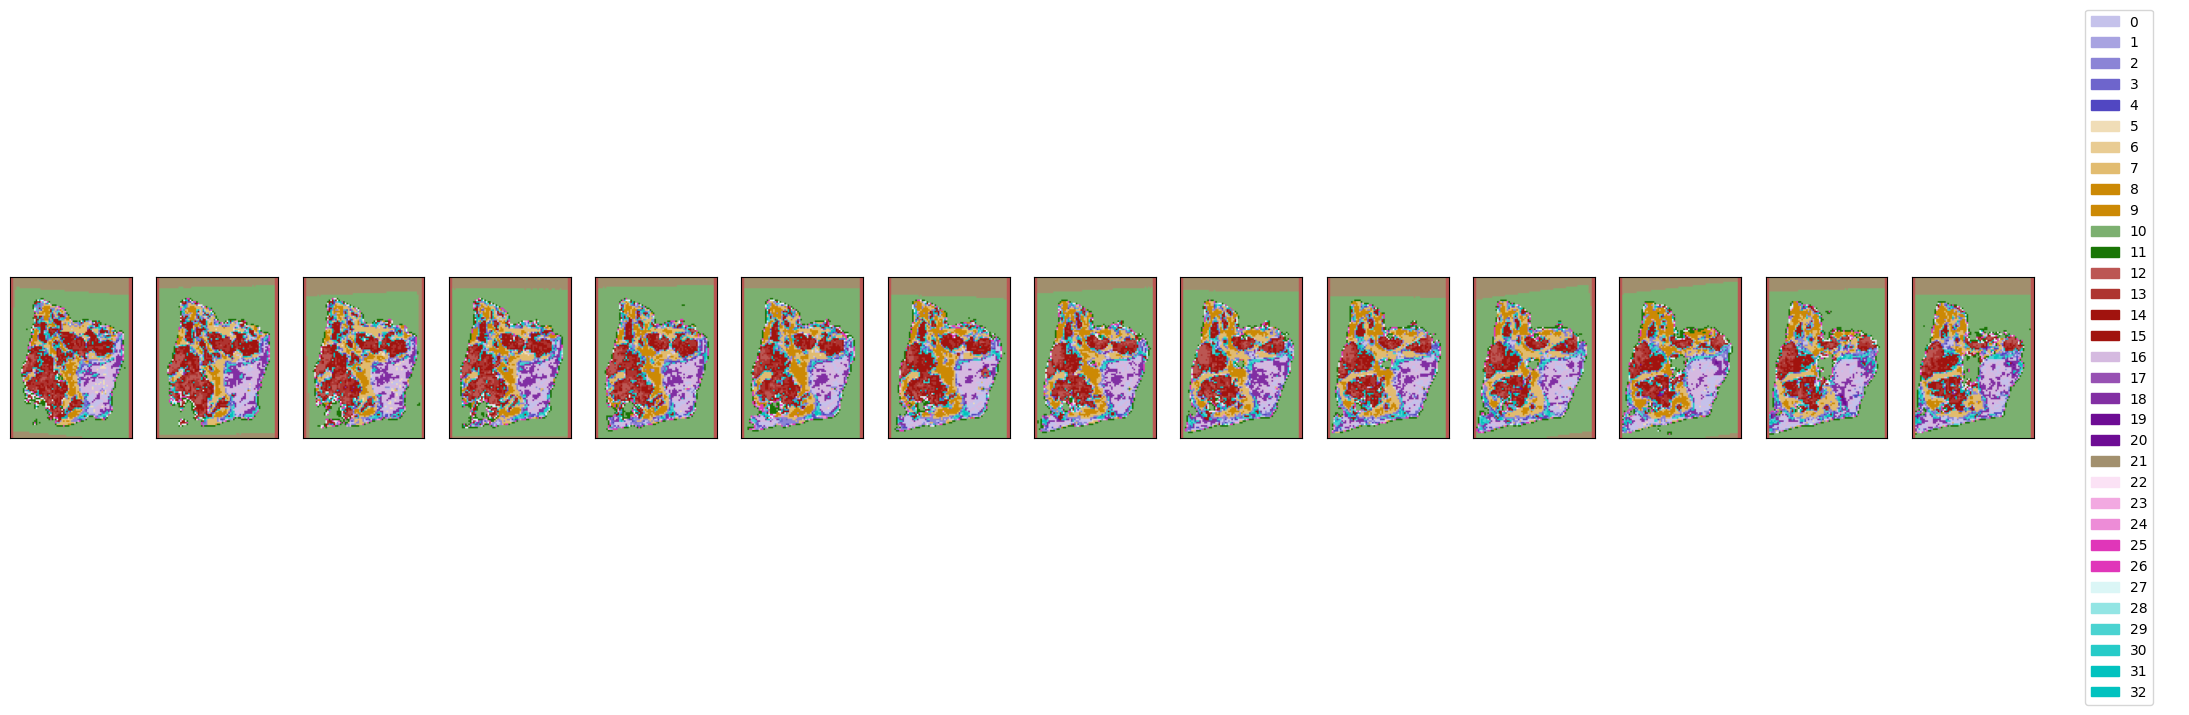

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 12 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 12 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closing g

multiplex 0


INFO:fontTools.subset:hhea subsetting not needed
INFO:fontTools.subset:maxp subsetting not needed
INFO:fontTools.subset:OS/2 subsetting not needed
INFO:fontTools.subset:hmtx subsetted
INFO:fontTools.subset:cmap subsetted
INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.sub

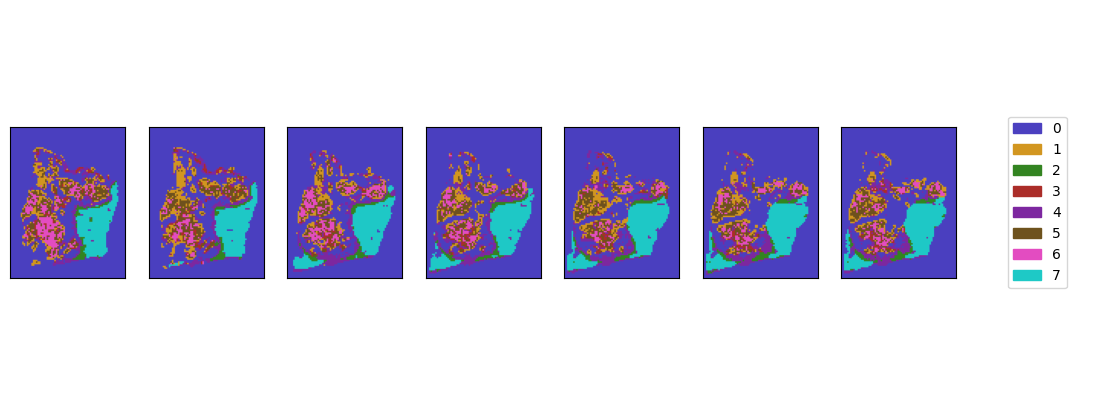

multiplex 1


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

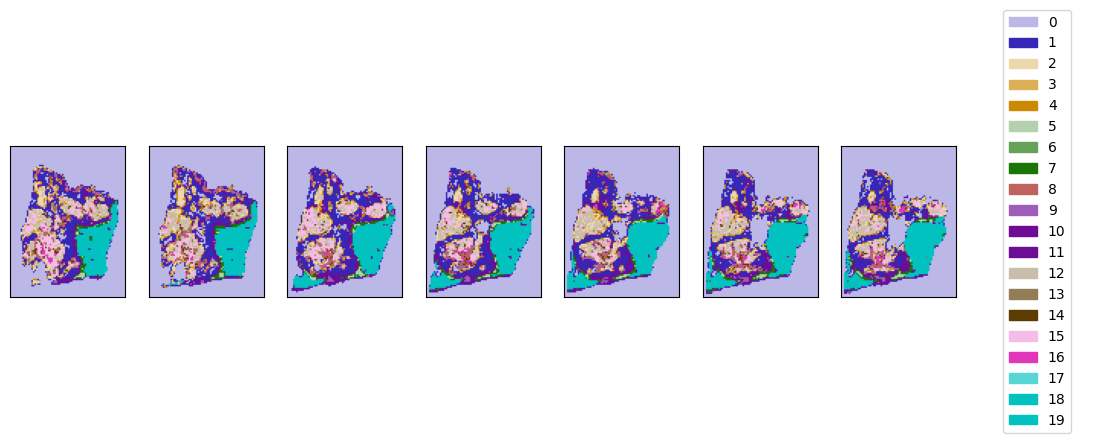

multiplex 2


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

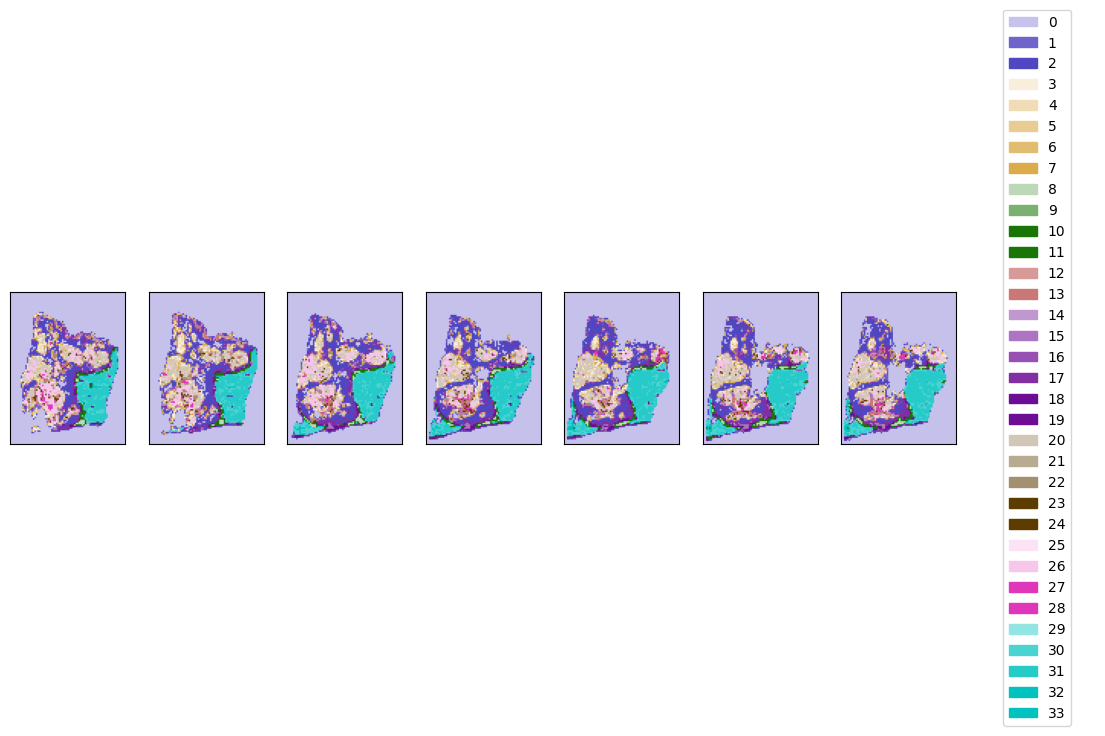

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 12 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 12 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closing g

xenium 0


INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned


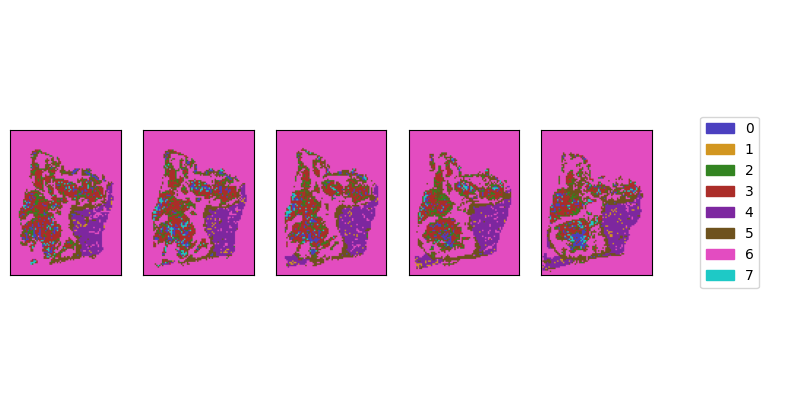

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

xenium 1


INFO:fontTools.subset:Closed glyph list over 'glyf': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Retaining 14 glyphs
INFO:fontTools.subset:head subsetting not needed
INFO:fontTools.subset:hhea subsetting not needed
INFO:fontTools.subset:maxp subsetting not needed
INFO:fontTools.subset:OS/2 subsetting not needed
INFO:fontTools.subset:hmtx subsetted
INFO:fontTools.subset:cmap subsetted
INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontT

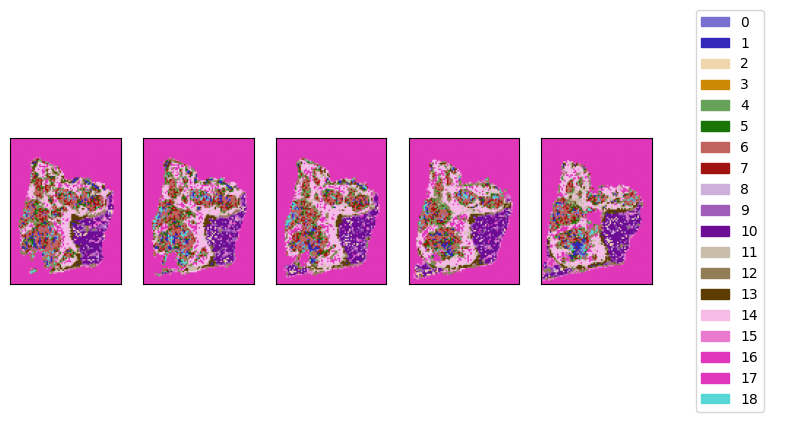

xenium 2


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

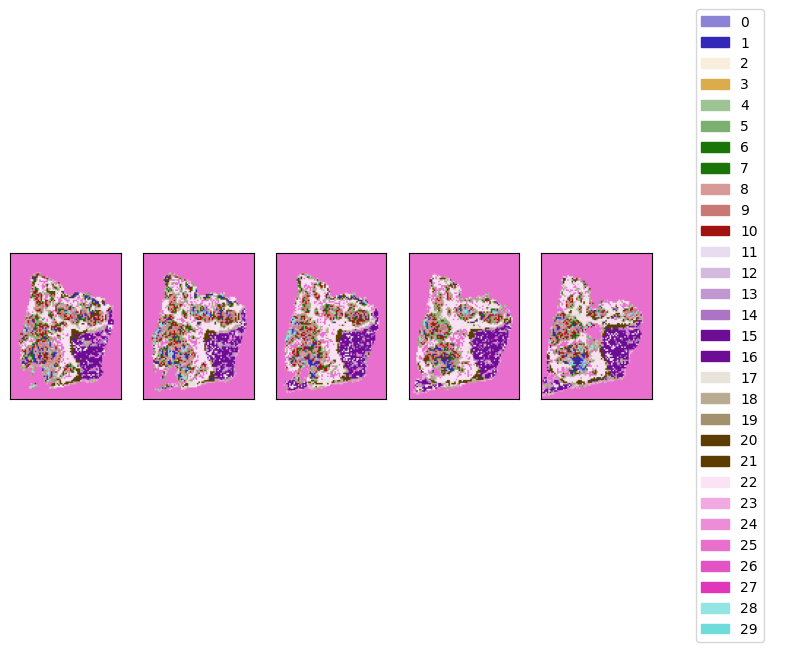

INFO:root:generating volume for cosmx spore
INFO:root:generating volume for he spore


0


INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 17 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'space', 't', 'u', 'x']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 70, 72, 75, 76, 79, 80, 81, 82, 83, 86, 87, 88, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 17 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'space', 't', 'u',

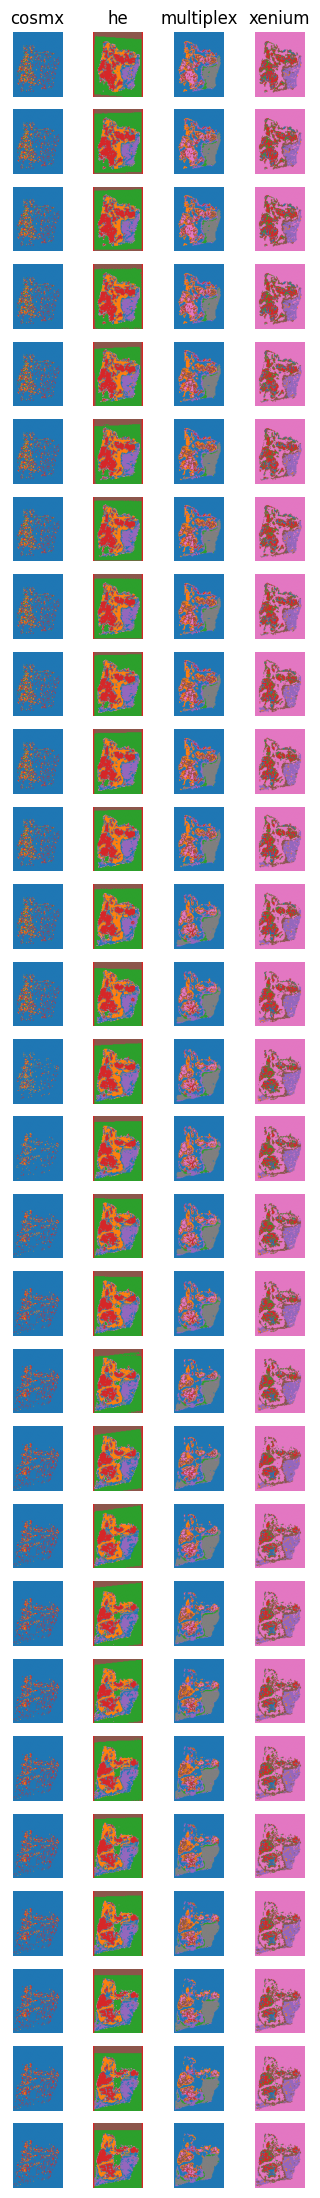

INFO:root:generating volume for cosmx spore
INFO:root:generating volume for he spore


1


INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 17 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'space', 't', 'u', 'x']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 70, 72, 75, 76, 79, 80, 81, 82, 83, 86, 87, 88, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 17 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'space', 't', 'u',

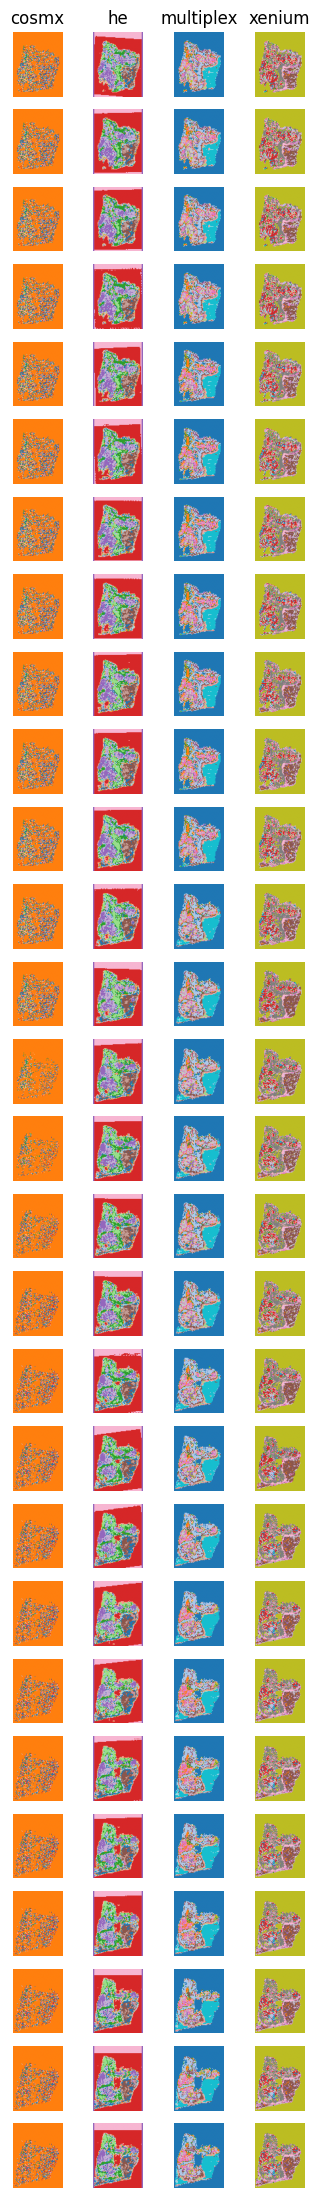

INFO:root:generating volume for cosmx spore


2


INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 17 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'space', 't', 'u', 'x']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 70, 72, 75, 76, 79, 80, 81, 82, 83, 86, 87, 88, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 17 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'e', 'h', 'i', 'l', 'm', 'n', 'nonmarkingr

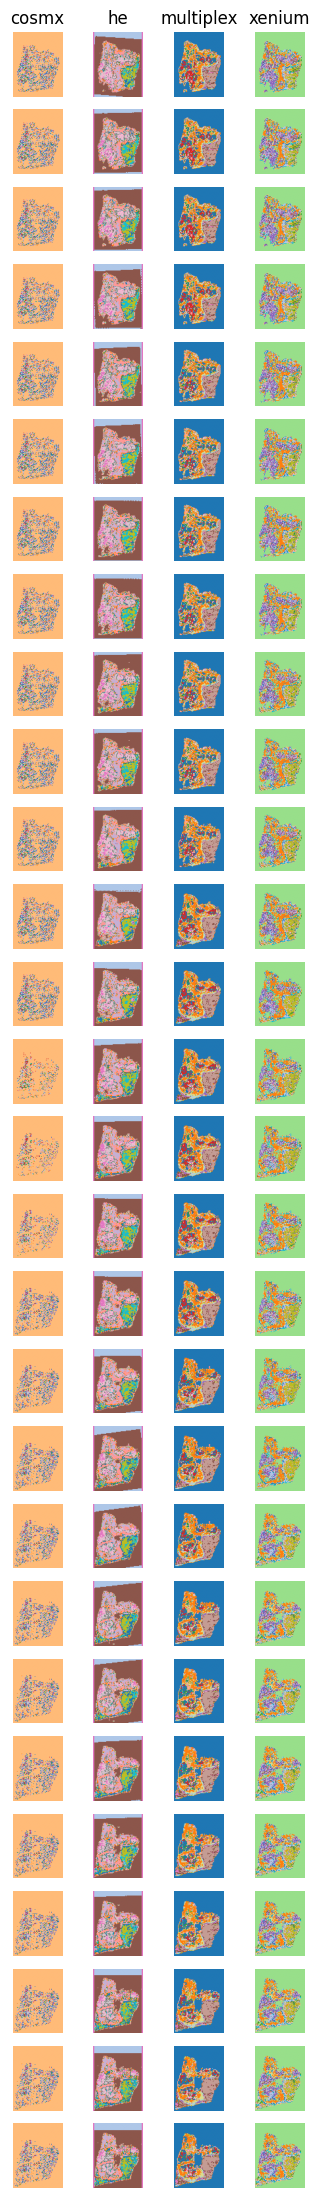

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res


AttributeError: 'Spore' object has no attribute 'cluser_to_agg'

In [23]:
for (case, target_res), config in case_to_config.items():
    print(case, target_res)
    dtype_to_weight = dtype_to_weight_mapping.get(case)
    
    mushroom = Mushroom.from_config(config)
    print(mushroom.section_ids)
    for dt in mushroom.dtypes:
        x = next(iter(mushroom.dtype_to_spore[dt].train_dl.dataset.section_to_img.values()))
        print(dt, x.shape)
        print(mushroom.input_ppm, mushroom.target_ppm)
    mushroom.train()
    mushroom.embed_sections()
    
    out_dir = mushroom.trainer_kwargs['out_dir']
    fig_dir = os.path.join(out_dir, 'figures')
    Path(fig_dir).mkdir(parents=True, exist_ok=True)
    
    for dtype in mushroom.dtypes:
        for level in range(mushroom.num_levels):
            print(dtype, level)
            mushroom.display_clusters(dtype, level=level)
            plt.savefig(os.path.join(fig_dir, f'nbhds_{dtype}_l{level}.pdf'), dpi=300)
            plt.savefig(os.path.join(fig_dir, f'nbhds_{dtype}_l{level}.png'), dpi=300)
            plt.show()
            
    for level, cluster_res in enumerate(cluster_resolutions):
        print(level)
#         dtype_to_volume = mushroom.generate_interpolated_volumes(
#             z_scaler=z_scaler, level=level, integrate=True, dtype_to_weight=dtype_to_weight, resolution=cluster_res)
        dtype_to_volume = mushroom.generate_interpolated_volumes(
            z_scaler=z_scaler, level=level, integrate=False, dtype_to_weight=dtype_to_weight, resolution=cluster_res)
        dtype_to_volume_labels = {k:v.argmax(-1) if k != 'integrated' else v for k, v in dtype_to_volume.items()}

        mushroom.display_volumes(dtype_to_volume=dtype_to_volume_labels, positions=mushroom.section_positions)

        plt.savefig(os.path.join(fig_dir, f'nbhd_volumes_l{level}.pdf'), dpi=300)
        plt.savefig(os.path.join(fig_dir, f'nbhd_volumes_l{level}.png'), dpi=300)
        plt.show()

        pickle.dump({
            'probs': dtype_to_volume,
            'labeled': dtype_to_volume_labels
        }, open(os.path.join(out_dir, f'nbhd_volumes_l{level}.pkl'), 'wb'), protocol=4)

        del(dtype_to_volume)
        del(dtype_to_volume_labels)
        
    clustering_params = {
        'z_scaler': z_scaler,
        'cluster_resolutions': cluster_resolutions,
        'dtype_to_weight': dtype_to_weight
    }
    yaml.safe_dump(clustering_params, open(os.path.join(out_dir, 'nbhd_volume_params.yaml'), 'w'))
    
    mushroom.save()
    
    del(mushroom)
    
    

In [25]:
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s0_HT225C1-U2_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s0_HT225C1-U2_he.tif'}],
   'position': 0,
   'sid': 'HT225C1-U2'},
  {'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s1_HT225C1-U3_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s1_HT225C1-U3_he.tif'}],
   'position': 60,
   'sid': 'HT225C1-U3'},
  {'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s2_HT225C1-U4_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s2_HT225C1-U4_he.tif'}],
   'position': 120,
   'sid': 'HT225C1-U4'},
  {'data':